In [12]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [14]:
data1 = pd.read_csv("NEW-DATA-1.T15.txt", sep=' ')
data2 = pd.read_csv("NEW-DATA-2.T15.txt", sep=' ')

In [15]:
target = '3:Temperature_Comedor_Sensor'
cols = [
    '3:Temperature_Comedor_Sensor',
 '4:Temperature_Habitacion_Sensor',
 '5:Weather_Temperature',
 '6:CO2_Comedor_Sensor',
 '7:CO2_Habitacion_Sensor',
 '8:Humedad_Comedor_Sensor',
 '9:Humedad_Habitacion_Sensor',
 '10:Lighting_Comedor_Sensor',
 '11:Lighting_Habitacion_Sensor',
 '12:Precipitacion',
 '13:Meteo_Exterior_Crepusculo',
 '14:Meteo_Exterior_Viento',
 '15:Meteo_Exterior_Sol_Oest',
 '16:Meteo_Exterior_Sol_Est',
 '20:Exterior_Entalpic_2',
 '21:Exterior_Entalpic_turbo',
 '22:Temperature_Exterior_Sensor']

In [48]:
data2.tail(2)

,#,Unnamed: 1,1:Date,2:Time,3:Temperature_Comedor_Sensor,4:Temperature_Habitacion_Sensor,5:Weather_Temperature,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,...,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,19:Exterior_Entalpic_1,20:Exterior_Entalpic_2,21:Exterior_Entalpic_turbo,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor,24:Day_Of_Week
1371,02/05/2012,07:15,18.8133,18.2153,12.5333,200.107,200.597,43.3440,44.7013,28.1647,...,15796.9,354.645,0,0,0,15.7260,56.8613,3.0,NaN,NaN
1372,02/05/2012,07:30,18.8600,18.2667,13.0000,200.149,199.541,43.6667,44.5653,31.1107,...,19035.5,404.992,0,0,0,16.2693,55.8907,3.0,NaN,NaN


In [64]:
train_size = 3200
val_size = 400
depth = 90
batch_size = 128
prediction_horizon = 1

In [44]:
def preprocess(data):
    planeX = np.zeros((len(data), depth, len(cols)))
    vectorY = np.zeros((len(data), 1))
    for i, name in enumerate(cols):
        for j in range(depth):
            planeX[:, j, i] = data[name].shift(depth - j - 1).fillna(method="bfill")
    vectorY = data[target].shift(-prediction_horizon).fillna(method='ffill')
    x = planeX[depth:-prediction_horizon]
    y = vectorY[depth:-prediction_horizon]
    return x, y  
len(data1)

2764

In [52]:
trainX = np.zeros((len(data), depth, len(cols)))
trainY = np.zeros((len(data), 1))
for i, name in enumerate(cols):
    for j in range(depth):
        trainX[:, j, i] = data[name].shift(depth - j - 1).fillna(method="bfill")
trainY = data[target].shift(-prediction_horizon).fillna(method='ffill')

In [13]:
trainX = trainX[depth:-prediction_horizon]
trainY = trainY[depth:-prediction_horizon]

In [14]:
X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

In [39]:
for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

In [42]:
X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]
train_size-len(data1)

436

In [17]:
X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

In [18]:
X_train = np.concatenate([trainX, X_train2], axis=0)
y_train = np.concatenate([trainY, y_train2], axis=0)

In [19]:
X_train.shape, y_train.shape

((3019, 90, 17), (3019,))

In [21]:
X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

In [22]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)


In [24]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

In [25]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)


In [30]:
class ConvRNN(nn.Module):
    def __init__(self, input_dim, timesteps, output_dim, kernel_size1=7, kernel_size2=5, kernel_size3=3, 
                 n_channels1=32, n_channels2=32, n_channels3=32, n_units1=32, n_units2=32, n_units3=32):
        super().__init__()
        self.avg_pool1 = nn.AvgPool1d(2, 2)
        self.avg_pool2 = nn.AvgPool1d(4, 4)
        self.conv11 = nn.Conv1d(input_dim, n_channels1, kernel_size=kernel_size1)
        self.conv12 = nn.Conv1d(n_channels1, n_channels1, kernel_size=kernel_size1)
        self.conv21 = nn.Conv1d(input_dim, n_channels2, kernel_size=kernel_size2)
        self.conv22 = nn.Conv1d(n_channels2, n_channels2, kernel_size=kernel_size2)
        self.conv31 = nn.Conv1d(input_dim, n_channels3, kernel_size=kernel_size3)
        self.conv32 = nn.Conv1d(n_channels3, n_channels3, kernel_size=kernel_size3)
        self.gru1 = nn.GRU(n_channels1, n_units1, batch_first=True)
        self.gru2 = nn.GRU(n_channels2, n_units2, batch_first=True)
        self.gru3 = nn.GRU(n_channels3, n_units3, batch_first=True)
        self.linear1 = nn.Linear(n_units1+n_units2+n_units3, output_dim)
        self.linear2 = nn.Linear(input_dim*timesteps, output_dim)
        self.zp11 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp12 = nn.ConstantPad1d(((kernel_size1-1), 0), 0)
        self.zp21 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp22 = nn.ConstantPad1d(((kernel_size2-1), 0), 0)
        self.zp31 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        self.zp32 = nn.ConstantPad1d(((kernel_size3-1), 0), 0)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        # line1
        y1 = self.zp11(x)
        y1 = torch.relu(self.conv11(y1))
        y1 = self.zp12(y1)
        y1 = torch.relu(self.conv12(y1))
        y1 = y1.permute(0, 2, 1)
        out, h1 = self.gru1(y1)
        # line2
        y2 = self.avg_pool1(x)
        y2 = self.zp21(y2)
        y2 = torch.relu(self.conv21(y2))
        y2 = self.zp22(y2)
        y2 = torch.relu(self.conv22(y2))
        y2 = y2.permute(0, 2, 1)
        out, h2 = self.gru2(y2)
        # line3 
        y3 = self.avg_pool2(x)
        y3 = self.zp31(y3)
        y3 = torch.relu(self.conv31(y3))
        y3 = self.zp32(y3)
        y3 = torch.relu(self.conv32(y3))
        y3 = y3.permute(0, 2, 1)
        out, h3 = self.gru3(y3)
        h = torch.cat([h1[-1], h2[-1], h3[-1]], dim=1)
        out1 = self.linear1(h)
        out2 = self.linear2(x.contiguous().view(x.shape[0], -1))
        out = out1 + out2
        return out

In [31]:
model = ConvRNN(X_train.shape[2], X_train.shape[1], 1, n_channels1=128, n_channels2=128, n_channels3=128,
                n_units1=128, n_units2=128, n_units3=128).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [34]:
import time

Saving...
Iter:  0 train:  0.24197512347244948 val:  0.16678064223214134
Iter time:  1.0013861539991922
mse:  13.462839 mae:  2.978669


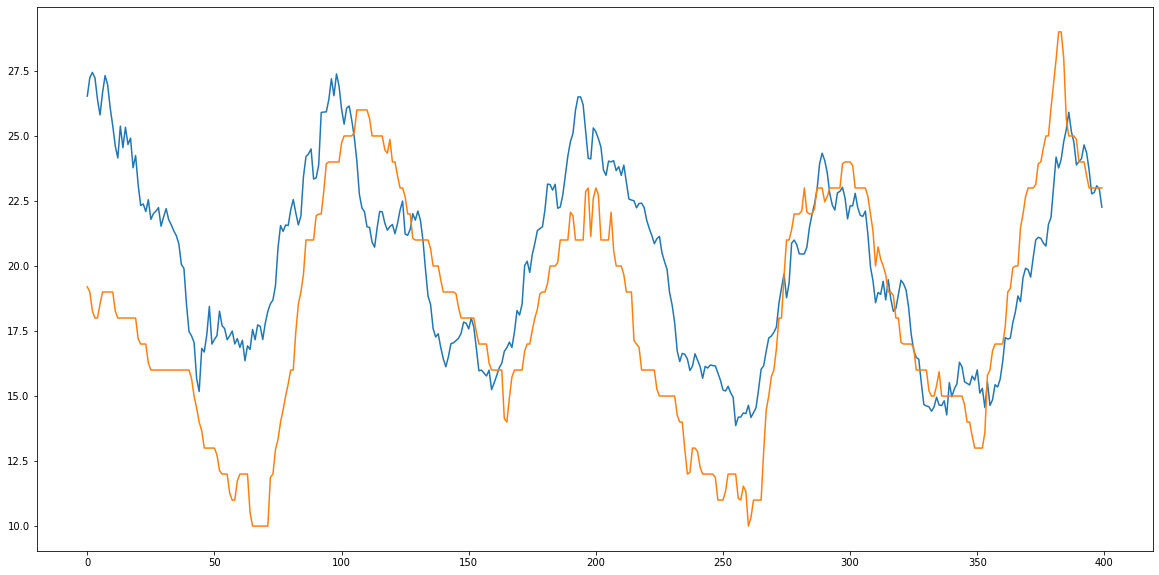

Saving...
Iter:  1 train:  0.11992188629921778 val:  0.11844392662333336
Iter time:  0.48513187099888455
Saving...
Iter:  2 train:  0.09353583773123637 val:  0.10716271549389739
Iter time:  0.45087484900068375
Saving...
Iter:  3 train:  0.0784919026164091 val:  0.09440980885890131
Iter time:  0.44857140999738476
Saving...
Iter:  4 train:  0.06461866182043086 val:  0.08240425545264486
Iter time:  0.4534704710022197
Iter:  5 train:  0.056251924081903604 val:  0.09104769186855079
Iter time:  0.447059555001033
Saving...
Iter:  6 train:  0.050835039134978124 val:  0.0790218347074818
Iter time:  0.46635532100117416
Saving...
Iter:  7 train:  0.0484584799922312 val:  0.07866208119690839
Iter time:  0.4824577199979103
Iter:  8 train:  0.04452969286439254 val:  0.07897134022451825
Iter time:  0.47934468800303875
Saving...
Iter:  9 train:  0.044409304085573184 val:  0.07589276750543253
Iter time:  0.4542224469987559
Saving...
Iter:  10 train:  0.04069680898878012 val:  0.07304521905582625
Iter t

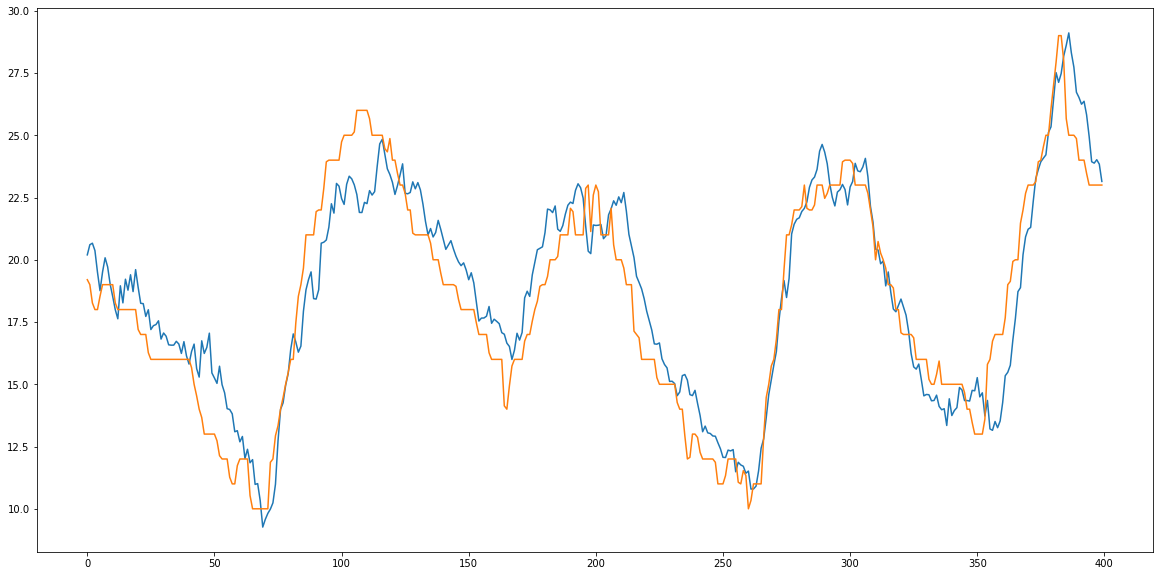

Iter:  11 train:  0.03898716010394119 val:  0.07891514322001417
Iter time:  0.44996816300044884
Saving...
Iter:  12 train:  0.038926817328554394 val:  0.07263667422296073
Iter time:  0.47068578000107664
Iter:  13 train:  0.038029782521089975 val:  0.07496814013829775
Iter time:  0.4684198969989666
Iter:  14 train:  0.034845747706985536 val:  0.07327885129699531
Iter time:  0.47049174099811353
Saving...
Iter:  15 train:  0.03485629630732735 val:  0.07077925045565915
Iter time:  0.45355875400127843
Saving...
Iter:  16 train:  0.03350126581094889 val:  0.06737839283477484
Iter time:  0.46612108199769864
Iter:  17 train:  0.0320907421120937 val:  0.06882963120439438
Iter time:  0.47208604300249135
Iter:  18 train:  0.03146179408343439 val:  0.06783978405557364
Iter time:  0.4781327529999544
Saving...
Iter:  19 train:  0.032707871295327 val:  0.06523511966120403
Iter time:  0.4663167699982296
Saving...
Iter:  20 train:  0.0334928441452393 val:  0.06433277714140725
Iter time:  0.474367065999

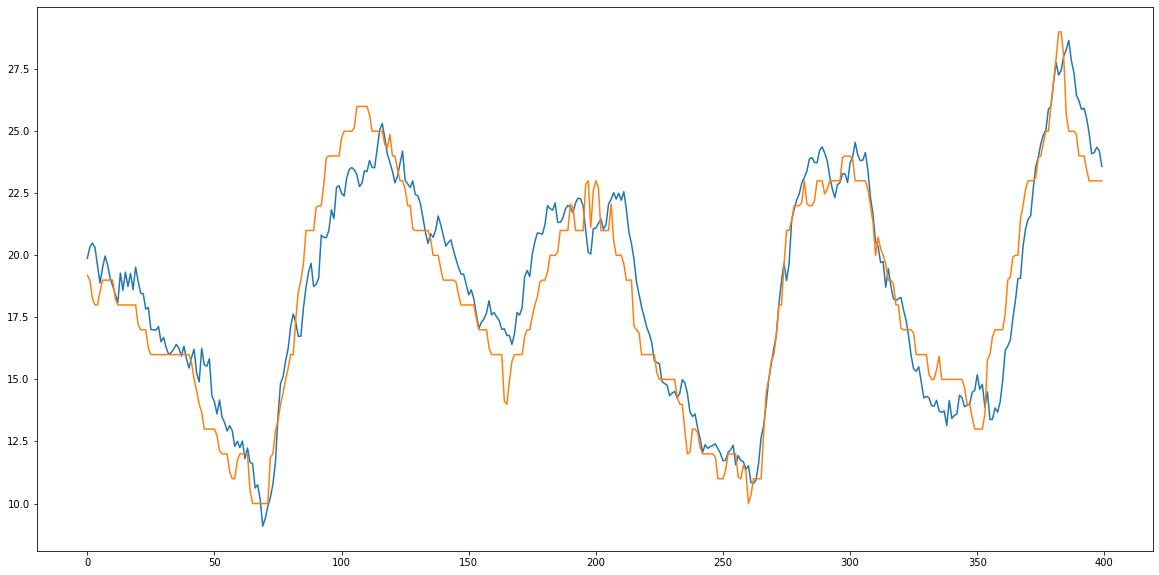

Iter:  21 train:  0.03207360062194596 val:  0.07625799250535069
Iter time:  0.4519570129996282
Iter:  22 train:  0.02873223718476286 val:  0.06911268855221149
Iter time:  0.4689895669980615
Saving...
Iter:  23 train:  0.02759051591148309 val:  0.06419053367402854
Iter time:  0.46796570300284657
Saving...
Iter:  24 train:  0.02754803029031318 val:  0.06352296395032064
Iter time:  0.5024155049977708
Iter:  25 train:  0.02668691108728518 val:  0.06633392939876834
Iter time:  0.46746178299872554
Iter:  26 train:  0.02802414506988154 val:  0.06415977739196123
Iter time:  0.46471260199905373
Iter:  27 train:  0.02930643932552661 val:  0.063807856856459
Iter time:  0.464630249000038
Iter:  28 train:  0.02631371913559325 val:  0.06973330788348259
Iter time:  0.48013370300031966
Iter:  29 train:  0.025598038400775597 val:  0.07159322102141887
Iter time:  0.4702468190007494
Iter:  30 train:  0.025075052097916474 val:  0.06476453544381247
Iter time:  0.461972851997416
mse:  2.0301113 mae:  1.1620

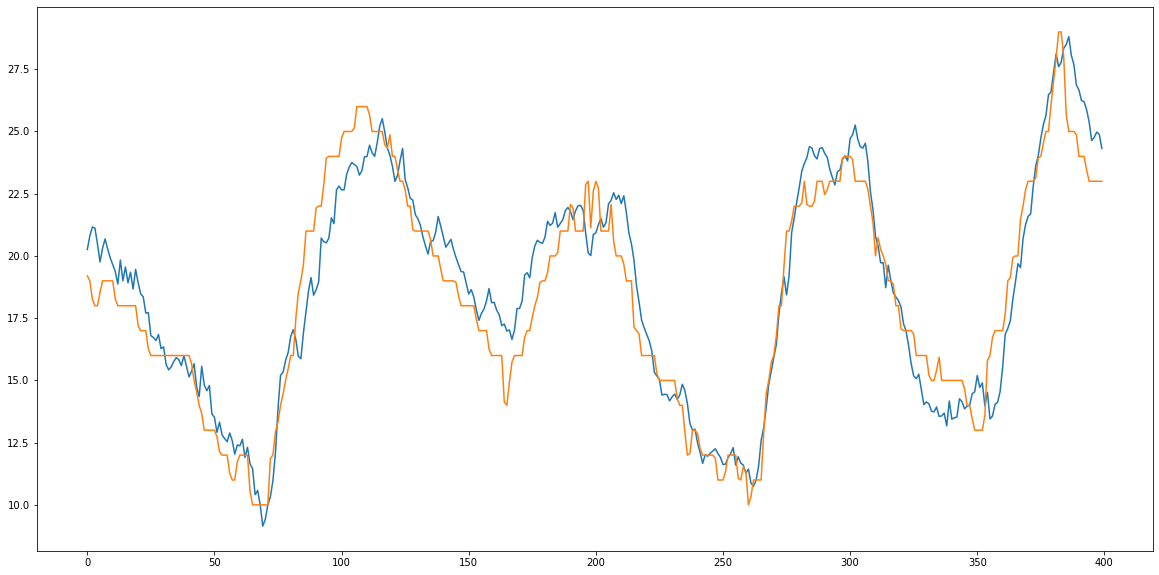

Iter:  31 train:  0.024518281708937745 val:  0.06515044906919616
Iter time:  0.4543893219997699
Saving...
Iter:  32 train:  0.025218294629521482 val:  0.06324595891912109
Iter time:  0.4587851779979246
Iter:  33 train:  0.023548113177833067 val:  0.07177075102754772
Iter time:  0.4601723679988936
Saving...
Iter:  34 train:  0.024139874218798915 val:  0.062466362901852424
Iter time:  0.4649464200010698
Iter:  35 train:  0.02280758045271391 val:  0.06485604520074102
Iter time:  0.46664458000304876
Iter:  36 train:  0.022989785827044928 val:  0.06925598961872677
Iter time:  0.47557861599852913
Iter:  37 train:  0.02296841316190298 val:  0.06386597541802169
Iter time:  0.484209586000361
Iter:  38 train:  0.02356057706810379 val:  0.06297324185879688
Iter time:  0.45595107400004053
Iter:  39 train:  0.027132979562131506 val:  0.0630149923657462
Iter time:  0.448800507998385
Iter:  40 train:  0.02812764804306306 val:  0.06726386532049138
Iter time:  0.45328869800141547
mse:  2.189823 mae:  1

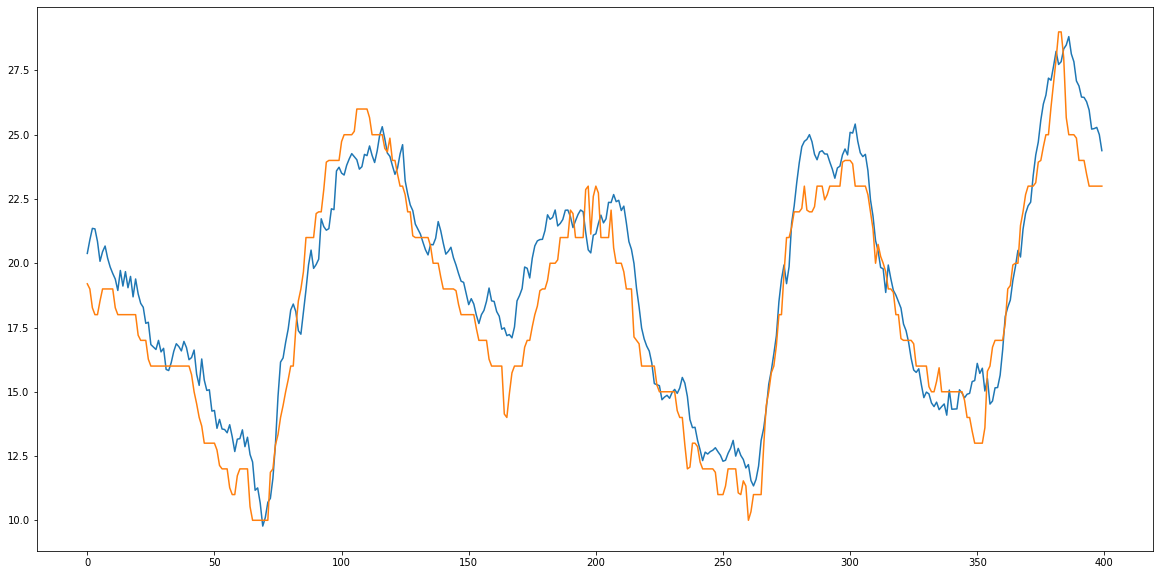

Iter:  41 train:  0.0326164544079493 val:  0.07527065267989033
Iter time:  0.4537053169988212
Iter:  42 train:  0.021883668872791907 val:  0.0647273659411645
Iter time:  0.4537452559998201
Saving...
Iter:  43 train:  0.023334691666556565 val:  0.059522076135186286
Iter time:  0.4912155679994612
Iter:  44 train:  0.02497338490024158 val:  0.07474580494087509
Iter time:  0.45339383000100497
Iter:  45 train:  0.022999867239014975 val:  0.060884903329994494
Iter time:  0.45167530399703537
Iter:  46 train:  0.02139183648112087 val:  0.06804850382558024
Iter time:  0.4560107609977422
Iter:  47 train:  0.019902226711940012 val:  0.06084017102932655
Iter time:  0.4668688210003893
Iter:  48 train:  0.019212894855117894 val:  0.06581740924759905
Iter time:  0.48415133000162314
Iter:  49 train:  0.018755958504232437 val:  0.06294453129136231
Iter time:  0.46361027900275076
Iter:  50 train:  0.018360869411535537 val:  0.0641678493422244
Iter time:  0.45359673100028886
mse:  1.9928762 mae:  1.17497

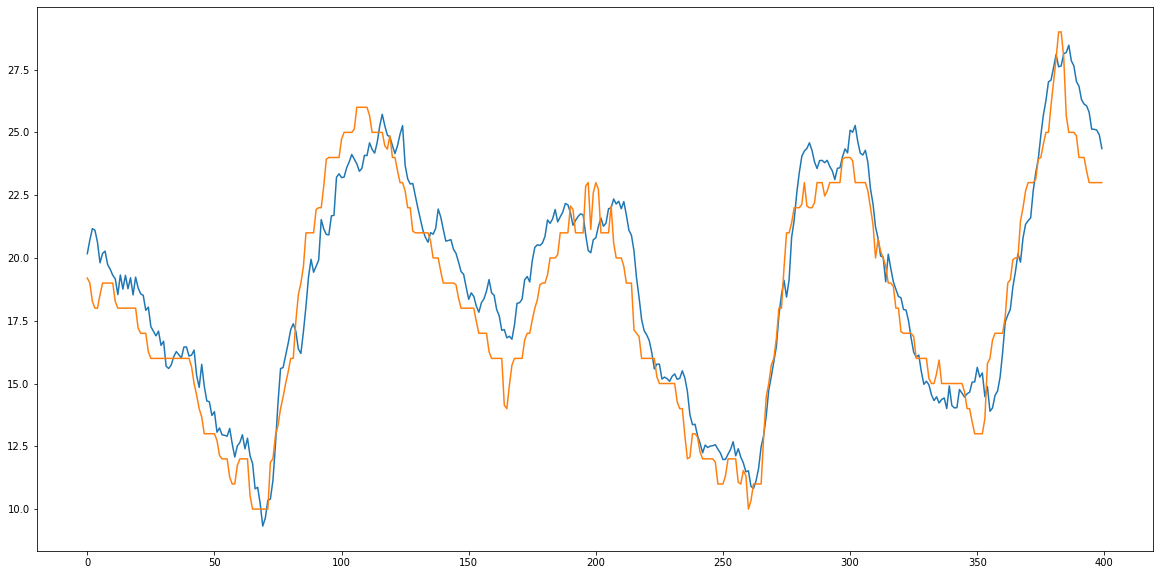

Iter:  51 train:  0.01918628100434691 val:  0.06925651084335085
Iter time:  0.470558439999877
Iter:  52 train:  0.01991220453444409 val:  0.06167127089788068
Iter time:  0.4561644620007428
Iter:  53 train:  0.01937954467945879 val:  0.060264418317183564
Iter time:  0.49080393799886224
Iter:  54 train:  0.0227276707478324 val:  0.06145178906840947
Iter time:  0.4721101319992158
Iter:  55 train:  0.019438935659318028 val:  0.062340366527460014
Iter time:  0.4519011410011444
Iter:  56 train:  0.020225440345433575 val:  0.06085654759603134
Iter time:  0.4727534560006461
Iter:  57 train:  0.01931713382956935 val:  0.05979157271001215
Iter time:  0.4559872079989873
Iter:  58 train:  0.017696364446439274 val:  0.061938583921249984
Iter time:  0.4517880290004541
Iter:  59 train:  0.017982924038403413 val:  0.06381577221647165
Iter time:  0.4542780669980857
Iter:  60 train:  0.01738690479097188 val:  0.06107690802186606
Iter time:  0.45483885900102905
mse:  1.8055081 mae:  1.0929586


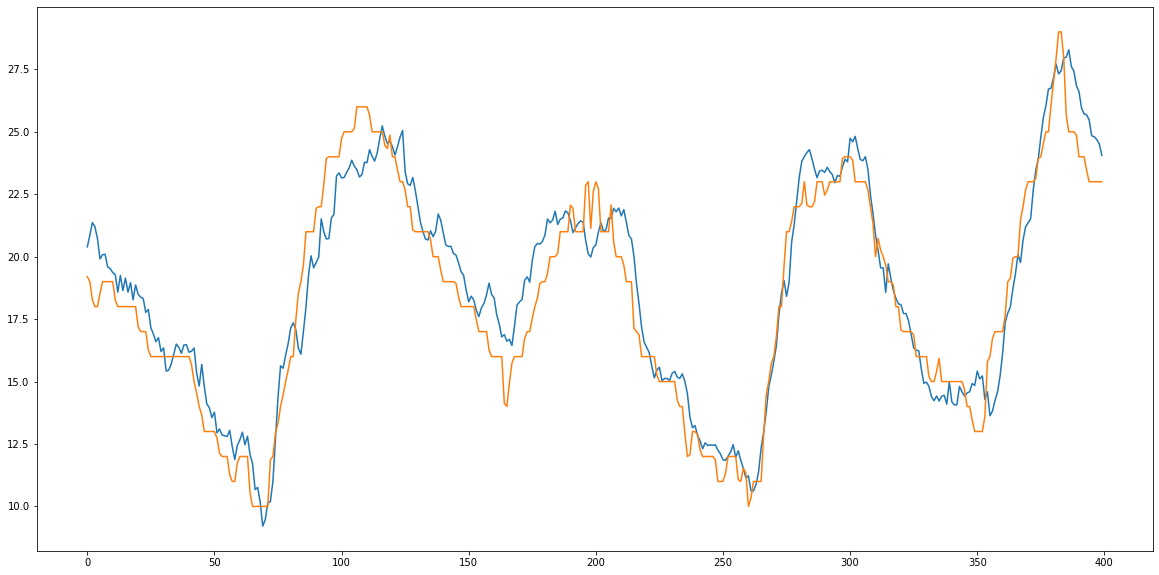

Iter:  61 train:  0.016777601909669804 val:  0.06144206675683089
Iter time:  0.47356528700038325
Iter:  62 train:  0.01798659357208571 val:  0.06145438663827724
Iter time:  0.47746428699974786
Iter:  63 train:  0.017290468656149773 val:  0.06200575281716144
Iter time:  0.4630951819999609
Iter:  64 train:  0.01928519926495468 val:  0.06124250181195081
Iter time:  0.4736333260007086
Iter:  65 train:  0.0174488208279634 val:  0.06320571836330771
Iter time:  0.45952439599932404
Iter:  66 train:  0.01922377459377558 val:  0.06037862720216478
Iter time:  0.45432352799980436
Iter:  67 train:  0.019251296165748003 val:  0.05958737144730427
Iter time:  0.45532596900011413
Iter:  68 train:  0.017028067964876905 val:  0.06212729369501926
Iter time:  0.4571672050005873
Iter:  69 train:  0.01742748781782927 val:  0.07277104118361896
Iter time:  0.4607291259999329
Saving...
Iter:  70 train:  0.01936229267217768 val:  0.05887346703766966
Iter time:  0.46435270399888395
mse:  1.6775851 mae:  1.0325171

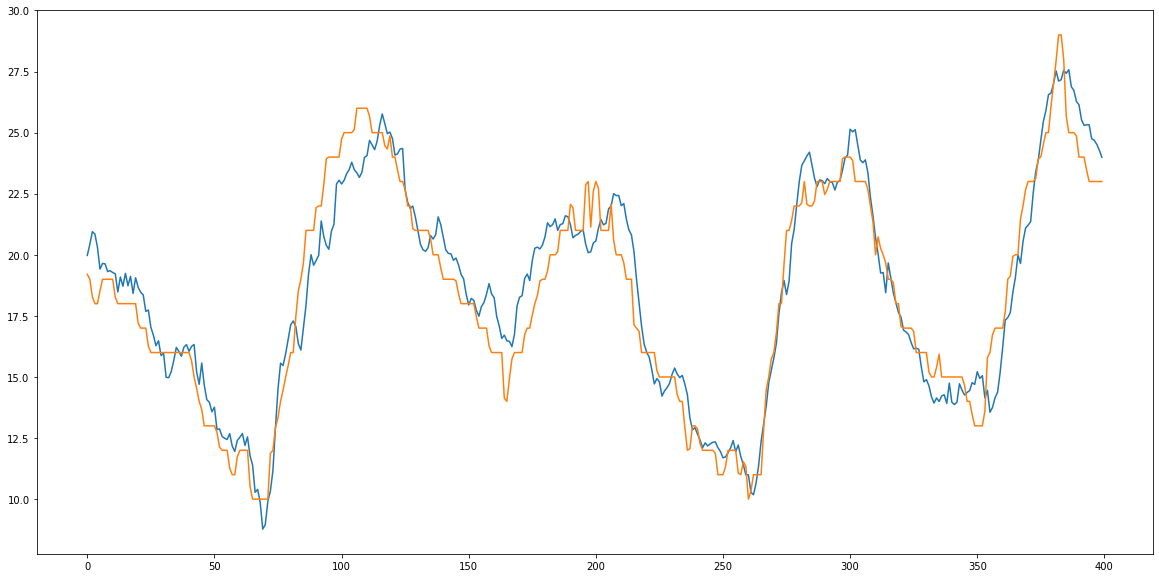

Iter:  71 train:  0.019905236049537353 val:  0.07155575914160432
Iter time:  0.4935469390002254
Iter:  72 train:  0.01805687490694276 val:  0.06515944426182849
Iter time:  0.4544071319978684
Iter:  73 train:  0.01712121816033015 val:  0.06178887689846908
Iter time:  0.4654099689978466
Iter:  74 train:  0.020742647758339887 val:  0.07092838416786038
Iter time:  0.4622494889990776
Iter:  75 train:  0.020056357210594282 val:  0.06181329716341011
Iter time:  0.4778806939975766
Iter:  76 train:  0.015401203115148877 val:  0.06205836396538878
Iter time:  0.4746457539986295
Iter:  77 train:  0.019598786988876824 val:  0.06042472330723687
Iter time:  0.46652627699950244
Iter:  78 train:  0.015612341440141085 val:  0.059543081375683246
Iter time:  0.4897587509985897
Iter:  79 train:  0.017418503369820166 val:  0.062136013388399726
Iter time:  0.4773889030002465
Iter:  80 train:  0.016076760158066666 val:  0.06330326309682424
Iter time:  0.48301024999818765
mse:  1.9395347 mae:  1.1508054


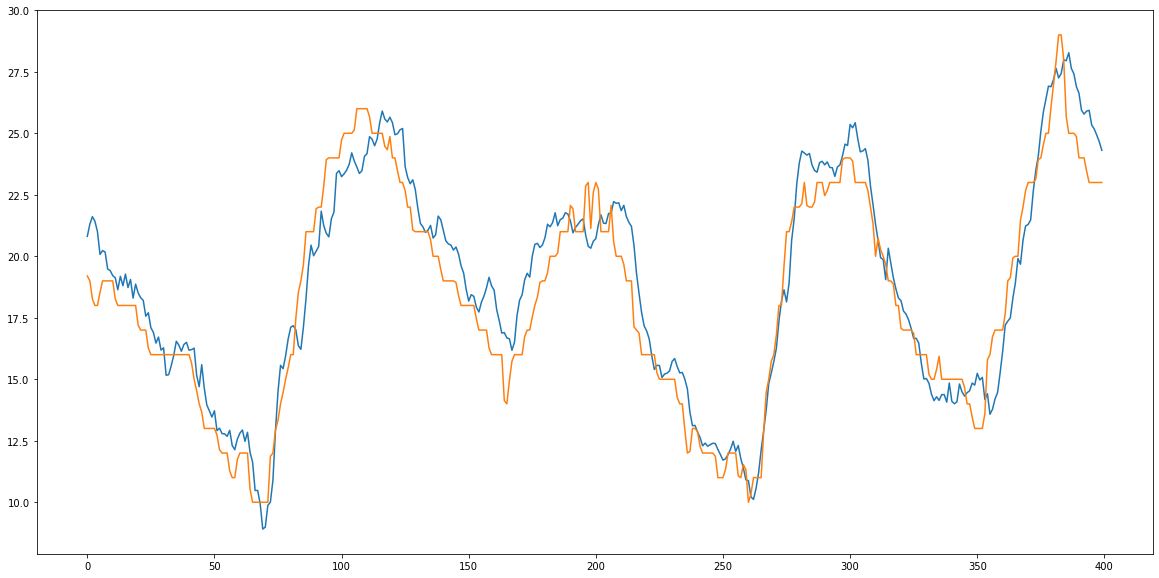

Saving...
Iter:  81 train:  0.01741106288733514 val:  0.05851956057587575
Iter time:  0.47847673000069335
Iter:  82 train:  0.016379828447964977 val:  0.06241991843307086
Iter time:  0.4644079640020209
Iter:  83 train:  0.017084783285930678 val:  0.0668555804827573
Iter time:  0.49601032699865755
Iter:  84 train:  0.016618173368932194 val:  0.06186711535044347
Iter time:  0.46840451399839367
Iter:  85 train:  0.0144459752395657 val:  0.060584580770878915
Iter time:  0.4771857669984456
Iter:  86 train:  0.015098724415516148 val:  0.06516918591402653
Iter time:  0.4618533719985862
Iter:  87 train:  0.015059378953640514 val:  0.06358106725695174
Iter time:  0.45758035100152483
Iter:  88 train:  0.016611043815353995 val:  0.06565543388665633
Iter time:  0.4782956919989374
Iter:  89 train:  0.015866787312226068 val:  0.06049316731402975
Iter time:  0.47199816099964664
Iter:  90 train:  0.023401689850587486 val:  0.05977361553979818
Iter time:  0.48660994800229673
mse:  1.7292763 mae:  1.061

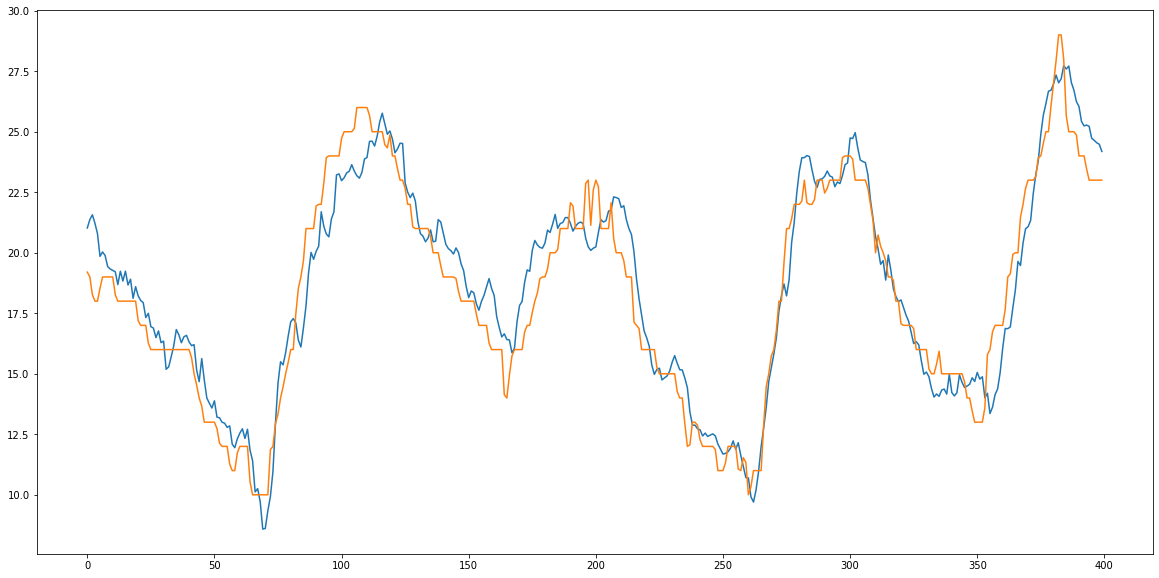

Iter:  91 train:  0.01859774711521414 val:  0.07038688539654323
Iter time:  0.459618890999991
Iter:  92 train:  0.017986094695046483 val:  0.061044610626398745
Iter time:  0.48420912099754787
Iter:  93 train:  0.015225821150063023 val:  0.0636008141083165
Iter time:  0.4736083930001769
Iter:  94 train:  0.014261289203586146 val:  0.06288558809474926
Iter time:  0.4679262509998807
Iter:  95 train:  0.015160160329512118 val:  0.059321956563257595
Iter time:  0.4619249050010694
Iter:  96 train:  0.015130381571779827 val:  0.06598664669125381
Iter time:  0.4601055950006412
Iter:  97 train:  0.016644781761505374 val:  0.061132632885995075
Iter time:  0.47623857500002487
Iter:  98 train:  0.014306092138133183 val:  0.06533165348553886
Iter time:  0.4759802430016862
Iter:  99 train:  0.018761809445400436 val:  0.0720754748203907
Iter time:  0.46437351599888643
Iter:  100 train:  0.014921802985655175 val:  0.06245799828890777
Iter time:  0.47504220900009386
mse:  1.8880848 mae:  1.1186807


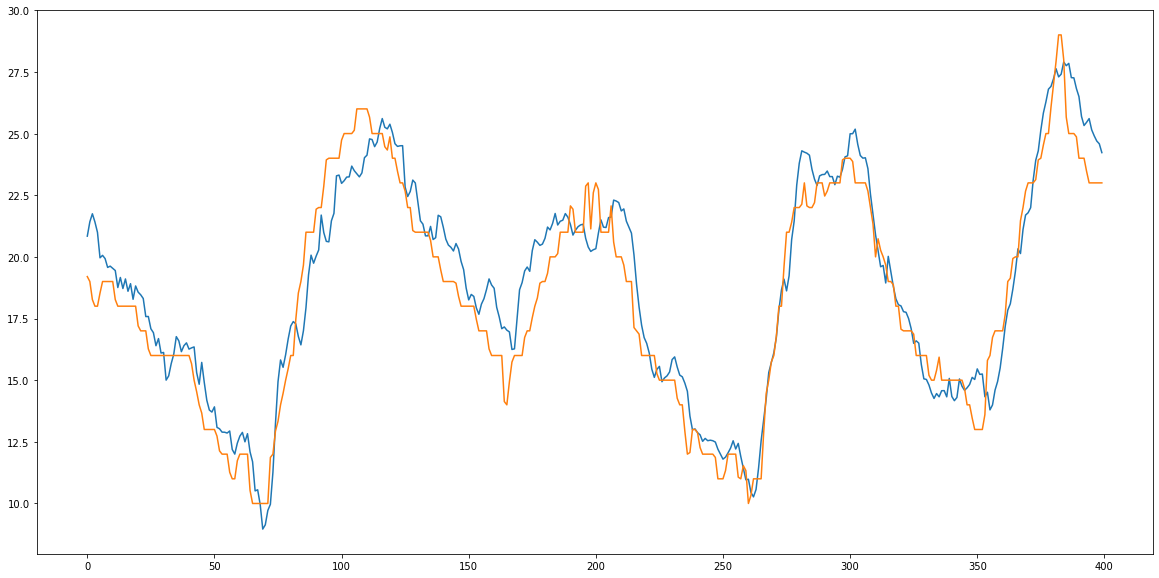

Iter:  101 train:  0.012697766032288392 val:  0.06384579361433024
Iter time:  0.48437577999720816
Iter:  102 train:  0.013741301815524869 val:  0.059461483587118835
Iter time:  0.48134030099754455
Iter:  103 train:  0.01336737762534219 val:  0.05916997716573401
Iter time:  0.4792980090023775
Iter:  104 train:  0.013051386279587173 val:  0.06362333348898397
Iter time:  0.4761308579982142
Iter:  105 train:  0.014568931173532315 val:  0.060446748698462074
Iter time:  0.4696455800003605
Iter:  106 train:  0.014646201478299477 val:  0.05920357631175065
Iter time:  0.47449068800051464
Iter:  107 train:  0.01617140543277013 val:  0.06427272809036932
Iter time:  0.46053350300280727
Saving...
Iter:  108 train:  0.014218265062436402 val:  0.05831110158467014
Iter time:  0.4646473270004208
Iter:  109 train:  0.014760138876002768 val:  0.06133963482968204
Iter time:  0.4561219360002724
Iter:  110 train:  0.012681168464887727 val:  0.06194038854286061
Iter time:  0.47779553099826444
mse:  1.8569199

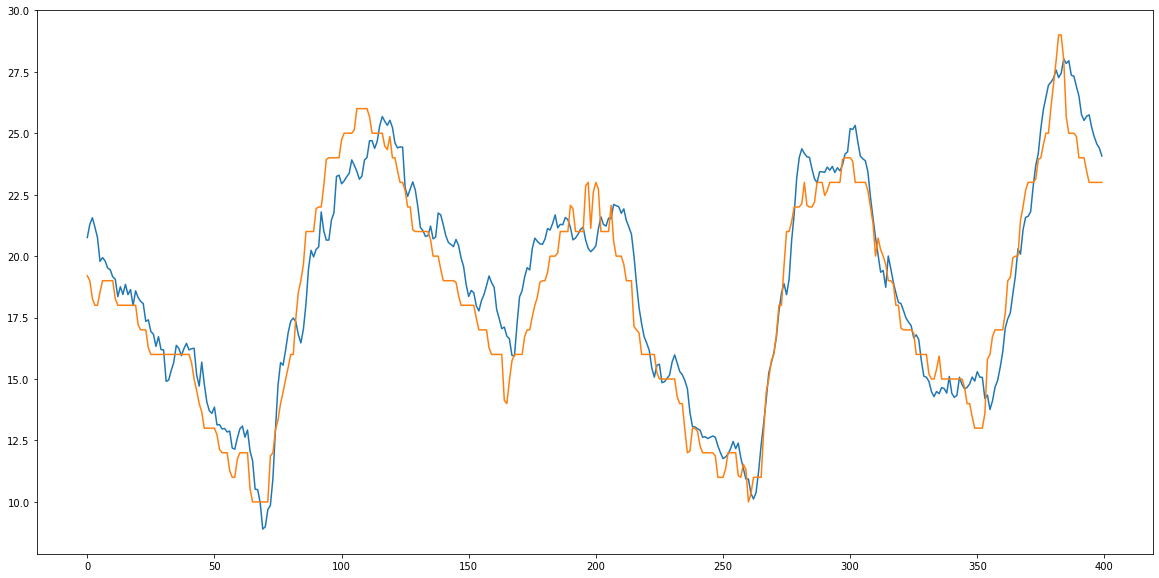

Iter:  111 train:  0.012552870370469461 val:  0.05906478267502182
Iter time:  0.45922060199882253
Iter:  112 train:  0.013875883958013643 val:  0.05936813910899203
Iter time:  0.463105398001062
Iter:  113 train:  0.01684385609623466 val:  0.06300731814829663
Iter time:  0.4605177999983425
Iter:  114 train:  0.01306945061666177 val:  0.05999073350646876
Iter time:  0.4843728359992383
Iter:  115 train:  0.013719082626049438 val:  0.059200220354417576
Iter time:  0.45868165899810265
Iter:  116 train:  0.015694328675707064 val:  0.0595269914916166
Iter time:  0.4879355970006145
Iter:  117 train:  0.012628059966644182 val:  0.061548082168915774
Iter time:  0.46154914400176494
Iter:  118 train:  0.012221767707792356 val:  0.06195232009605347
Iter time:  0.456323346003046
Iter:  119 train:  0.015689490174887164 val:  0.05914753285835916
Iter time:  0.45674420700015617
Iter:  120 train:  0.016968394639584872 val:  0.06528136422670924
Iter time:  0.45768076199965435
mse:  2.0626416 mae:  1.1897

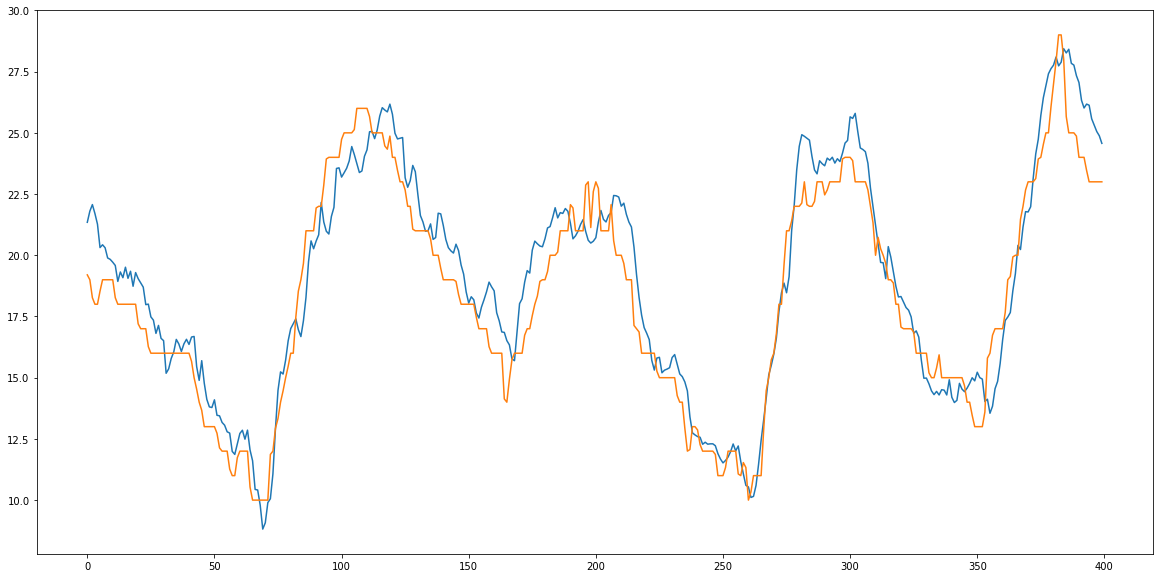

Iter:  121 train:  0.015318883538182943 val:  0.06128221679661161
Iter time:  0.4555245980009204
Iter:  122 train:  0.012554958259932586 val:  0.060178622507127834
Iter time:  0.4551474069994583
Iter:  123 train:  0.01262704739587973 val:  0.06166066351685832
Iter time:  0.4585215999977663
Iter:  124 train:  0.012191076766528128 val:  0.05971067058738657
Iter time:  0.45905124899945804
Iter:  125 train:  0.01275535412399868 val:  0.0625464392033875
Iter time:  0.489975576998404
Iter:  126 train:  0.011480972304920891 val:  0.06121150427326459
Iter time:  0.4736451130011119
Iter:  127 train:  0.014062174973844505 val:  0.062182266120533694
Iter time:  0.466273080000974
Iter:  128 train:  0.012669523277068134 val:  0.06386449907343238
Iter time:  0.46900487700258964
Iter:  129 train:  0.012776834675695091 val:  0.059952375875569376
Iter time:  0.4671551380015444
Iter:  130 train:  0.013246639120034561 val:  0.07161223072464812
Iter time:  0.4826385680025851
mse:  2.4821029 mae:  1.331539

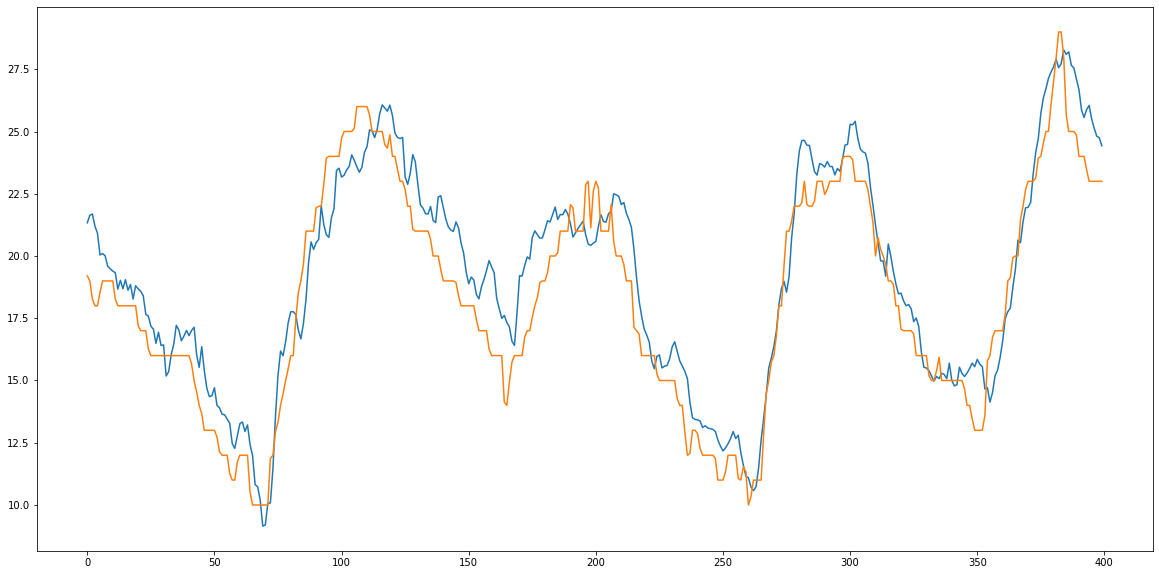

Iter:  131 train:  0.01595926733486525 val:  0.06306057426042536
Iter time:  0.4693415299989283
Iter:  132 train:  0.013935377571205583 val:  0.06169020031682887
Iter time:  0.49020703099813545
Iter:  133 train:  0.014685003088238132 val:  0.06253752639833046
Iter time:  0.5067431190000207
Iter:  134 train:  0.013307171625877886 val:  0.06636411620471497
Iter time:  0.4792000019988336
Iter:  135 train:  0.015790929357044767 val:  0.07106601939297615
Iter time:  0.46159633199931704
Iter:  136 train:  0.0184733262622242 val:  0.06275725825001019
Iter time:  0.4826381829989259
Iter:  137 train:  0.013028973265473972 val:  0.06186252398375784
Iter time:  0.48987406000014744
Iter:  138 train:  0.013054909460936504 val:  0.061951269588611683
Iter time:  0.4591274069971405
Iter:  139 train:  0.012055298762302774 val:  0.060247048369500074
Iter time:  0.48069987399867387
Iter:  140 train:  0.011779976088184312 val:  0.06377951819831648
Iter time:  0.49044601500281715
mse:  1.9688281 mae:  1.13

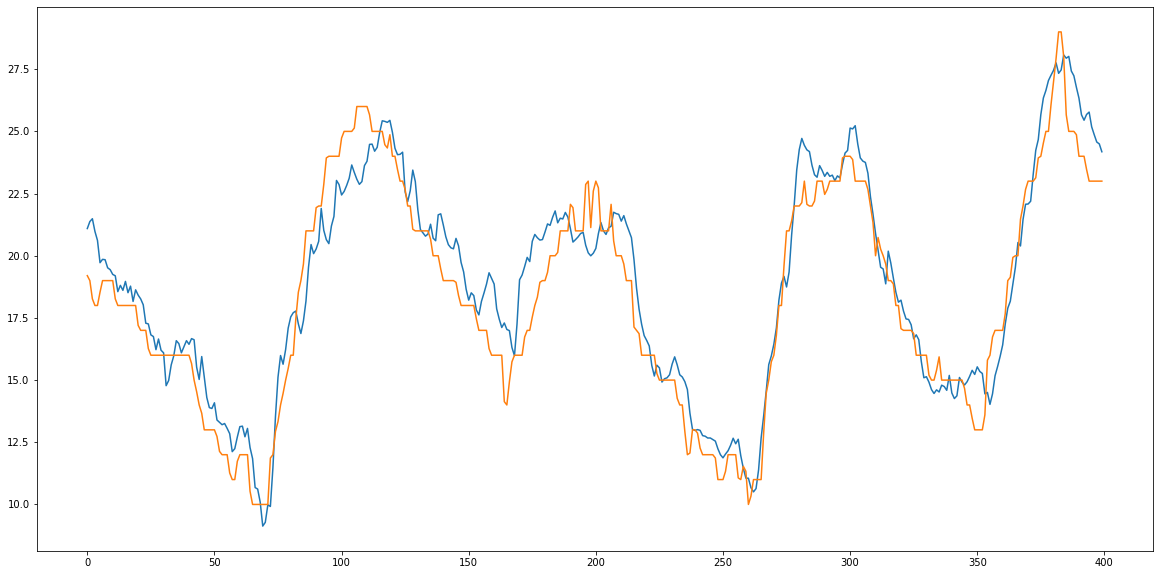

Iter:  141 train:  0.012592574879798923 val:  0.059273521073839174
Iter time:  0.4668891790024645
Iter:  142 train:  0.012974673256469324 val:  0.061515104849730745
Iter time:  0.47586726499866927
Iter:  143 train:  0.01114707263434678 val:  0.061222520643970144
Iter time:  0.4754954029995133
Iter:  144 train:  0.011165903573490576 val:  0.06501615309827394
Iter time:  0.4570995280009811
Iter:  145 train:  0.01138716308666025 val:  0.06616340044739652
Iter time:  0.4597469809996255
Iter:  146 train:  0.012550279564547242 val:  0.0620886348187883
Iter time:  0.47840289099985966
Iter:  147 train:  0.011033807107446982 val:  0.06268823708512611
Iter time:  0.45873786299853236
Iter:  148 train:  0.013377538227722594 val:  0.058563440271816786
Iter time:  0.45867461300076684
Iter:  149 train:  0.011310452903857853 val:  0.06270396597731036
Iter time:  0.4600490949997038
Iter:  150 train:  0.010535412694526567 val:  0.061052433467755476
Iter time:  0.45871963900208357
mse:  1.8040614 mae:  1

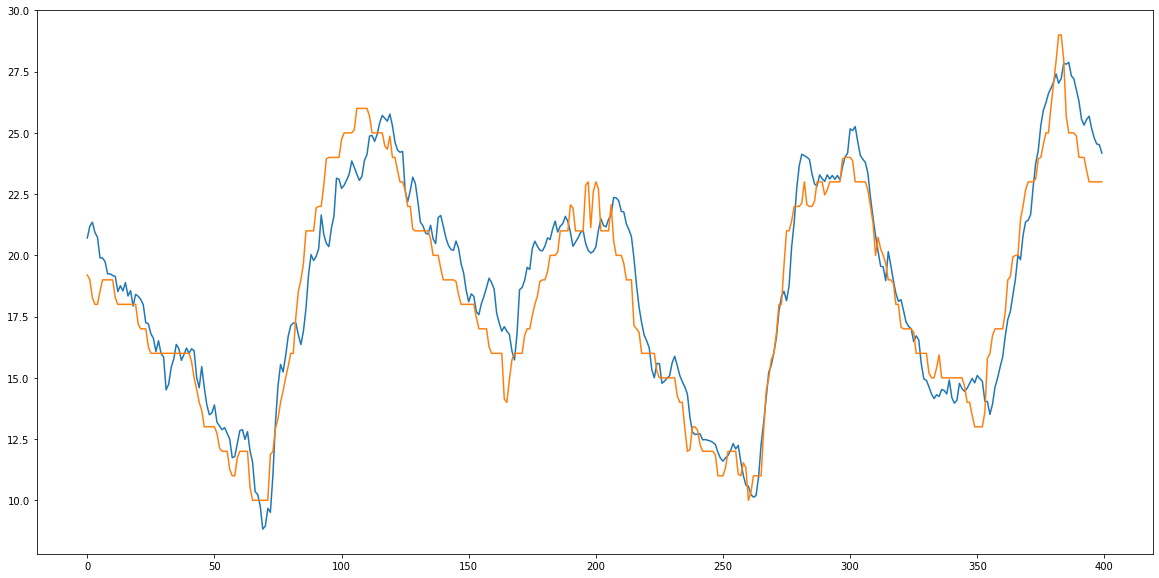

Iter:  151 train:  0.01055980640380121 val:  0.061529668916263394
Iter time:  0.4575211509982182
Iter:  152 train:  0.010264972671965075 val:  0.06424308045629651
Iter time:  0.4581829859998834
Iter:  153 train:  0.012374060450530936 val:  0.05997700010112463
Iter time:  0.47489006999967387
Iter:  154 train:  0.014479437554285185 val:  0.06563908874186833
Iter time:  0.47726868099925923
Iter:  155 train:  0.01507436575860423 val:  0.06250723707498981
Iter time:  0.506645233999734
Iter:  156 train:  0.012253288636062664 val:  0.06293491616480726
Iter time:  0.4654828060010914
Iter:  157 train:  0.01084804985713871 val:  0.06047502653928382
Iter time:  0.47232217000055243
Iter:  158 train:  0.010905041613295498 val:  0.065746312751471
Iter time:  0.4769566549985029
Iter:  159 train:  0.012405128343305274 val:  0.060634736024072454
Iter time:  0.4588109689975681
Iter:  160 train:  0.01186204793962018 val:  0.061743471168246036
Iter time:  0.4975917629999458
mse:  1.8451319 mae:  1.085483


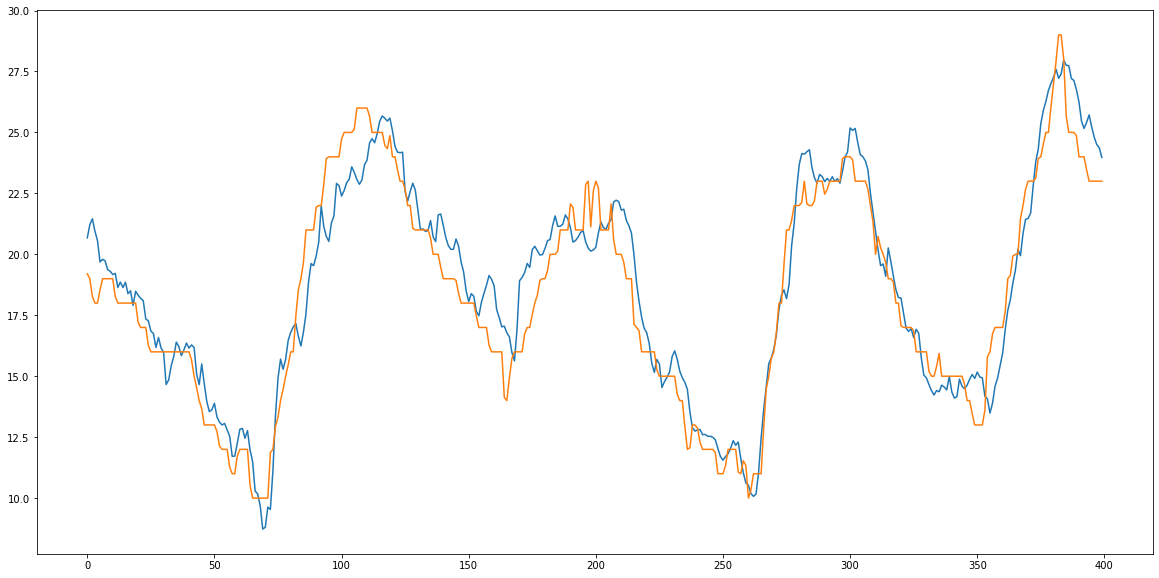

Iter:  161 train:  0.011866845864763947 val:  0.06042013716732553
Iter time:  0.46604505099821836
Iter:  162 train:  0.012276919976194614 val:  0.06003209312508157
Iter time:  0.45914996600185987
Iter:  163 train:  0.01130420265433392 val:  0.06298079069088768
Iter time:  0.45618593899780535
Iter:  164 train:  0.010186955022871745 val:  0.06309123947019668
Iter time:  0.46004142699894146
Iter:  165 train:  0.009771064061053193 val:  0.06422391420562451
Iter time:  0.47042208399943775
Iter:  166 train:  0.014697555263710058 val:  0.06462918770003402
Iter time:  0.45846809999784455
Iter:  167 train:  0.01104967444409167 val:  0.06450727644387275
Iter time:  0.4828140470017388
Iter:  168 train:  0.009965919071303873 val:  0.05961834862485256
Iter time:  0.4750161619995197
Iter:  169 train:  0.01219098926085375 val:  0.06411032752180834
Iter time:  0.4889489719971607
Iter:  170 train:  0.01270845662150019 val:  0.06726816126065961
Iter time:  0.45906824600024265
mse:  2.1901026 mae:  1.243

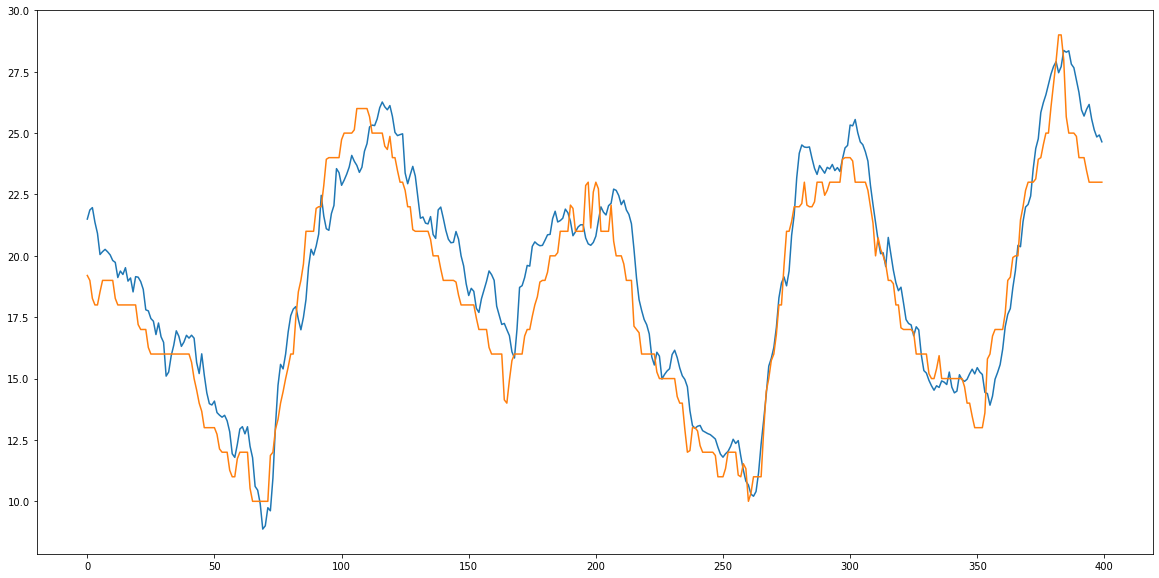

Iter:  171 train:  0.0166739186103097 val:  0.06647070337338742
Iter time:  0.4972194660003879
Iter:  172 train:  0.013481327686234069 val:  0.06195379059615617
Iter time:  0.4929144220004673
Iter:  173 train:  0.011230309059414129 val:  0.06197777787957988
Iter time:  0.45612250699923607
Iter:  174 train:  0.010403874526402778 val:  0.06015038941681227
Iter time:  0.45667864700226346
Iter:  175 train:  0.01101114781094474 val:  0.0608639080161499
Iter time:  0.47640274000150384
Iter:  176 train:  0.010606369229224404 val:  0.06016818987028031
Iter time:  0.4904889989993535
Iter:  177 train:  0.010973304953782697 val:  0.06265229861958686
Iter time:  0.4994077580013254
Iter:  178 train:  0.010421324178430611 val:  0.06579162980141633
Iter time:  0.48291304699887405
Iter:  179 train:  0.010462286897494313 val:  0.06116002363863152
Iter time:  0.4578615809987241
Iter:  180 train:  0.009569674980374428 val:  0.06491134435352952
Iter time:  0.48059052499957033
mse:  2.0393255 mae:  1.16734

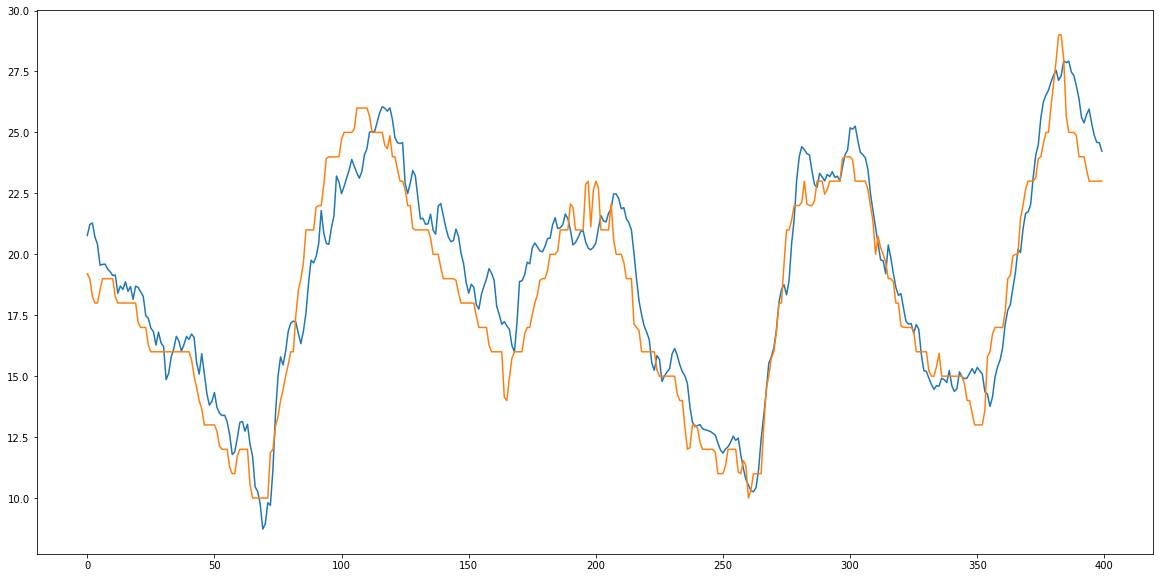

Iter:  181 train:  0.010394067710128541 val:  0.062925672835211
Iter time:  0.4974722010010737
Iter:  182 train:  0.011115504040661316 val:  0.061348237851946534
Iter time:  0.4946297370006505


In [35]:
epochs = 1000
loss = nn.MSELoss()
patience = 75
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    iteration_start = time.monotonic()
    for batch_x, batch_y in train_loader :
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        opt.zero_grad()
        y_pred = model(batch_x)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            output = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "convrnn_sml2010.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
    iteration_end = time.monotonic()
    print("Iter time: ", iteration_end - iteration_start)
    if(i % 10 == 0):
        preds = preds*(y_train_max - y_train_min) + y_train_min
        true = true*(y_train_max - y_train_min) + y_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

In [36]:
model.load_state_dict(torch.load("convrnn_sml2010.pt"))

<All keys matched successfully>

In [37]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [38]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [39]:
mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [40]:
mse, mae

(1.3528441, 0.93178964)

In [41]:
mse**0.5

1.1631182738964942

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true,'r')
plt.show()

NameError: name 'preds' is not defined

<Figure size 1440x720 with 0 Axes>

NameError: name 'preds' is not defined